### Libraries

In [1]:
import pandas as pd
import numpy as np
from scipy.io import arff
import seaborn as sns
import matplotlib.pyplot as plt
import openml
#our neural network
from neuralnetwork import Network,FCLayer,ActivationLayer,sigmoid,sigmoid_prime,tanh,tanh_prime,categorical_cross_entropy,categorical_cross_entropy_prime,mse,mse_prime,binary_cross_entropy,binary_cross_entropy_prime,relu,relu_prime
import time
#sklearn
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.metrics import recall_score,accuracy_score,confusion_matrix, ConfusionMatrixDisplay, precision_score, make_scorer,balanced_accuracy_score
from sklearn.model_selection import KFold
# from sklearn.model_selection import GridSearchCV,KFold,cross_val_score
import itertools
from imblearn.over_sampling import RandomOverSampler
import random

from neuralnetwork import Network,FCLayer,ActivationLayer
from neuralnetwork import sigmoid,sigmoid_prime,tanh,tanh_prime,categorical_cross_entropy,categorical_cross_entropy_prime,mse,mse_prime,softmax,softmax_prime


### Data

In [2]:
#directly downloading from openml
dataset = openml.datasets.get_dataset(1461)
X, y, categorical_indicator, attribute_names = dataset.get_data(
    dataset_format="dataframe", target=dataset.default_target_attribute)

In [3]:
df_bank = pd.DataFrame(X, columns=attribute_names)
df_bank["class"] = y

In [4]:
# rename columns
column_names_bank = ['age', 'job', 'marital', 'education', 'default',
                     'balance', 'housing', 'loan', 'contact', 'day',
                     'month', 'duration', 'campaign', 'pdays',
                     'previous', 'poutcome', 'class']
df_bank.columns = column_names_bank

In [5]:
df_bank.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,class
0,58,management,married,tertiary,no,2143.0,yes,no,unknown,5,may,261.0,1,-1.0,0.0,unknown,1
1,44,technician,single,secondary,no,29.0,yes,no,unknown,5,may,151.0,1,-1.0,0.0,unknown,1
2,33,entrepreneur,married,secondary,no,2.0,yes,yes,unknown,5,may,76.0,1,-1.0,0.0,unknown,1
3,47,blue-collar,married,unknown,no,1506.0,yes,no,unknown,5,may,92.0,1,-1.0,0.0,unknown,1
4,33,unknown,single,unknown,no,1.0,no,no,unknown,5,may,198.0,1,-1.0,0.0,unknown,1


In [6]:
df_bank.shape

(45211, 17)

### Preparing the data

In [7]:

#some jobs look like can be combined together into same category
df_bank['job'] = df_bank['job'].replace(['services','housemaid'], 'pink-collar')
df_bank['job'] = df_bank['job'].replace(['admin','management'], 'blue-collar')
df_bank['job'] = df_bank['job'].replace(['student','unemployed','retired'], 'other')

#dropping this column since it does not bring much value to our analysis
df_bank.drop('contact', axis=1, inplace=True)

#dropping these columns since they do not bring much value to our analysis
df_bank.drop('month', axis=1, inplace=True)
df_bank.drop('day', axis=1, inplace=True)

# Replacing 'other' with unknown since for both of them we do not have valuable information
df_bank['poutcome'] = df_bank['poutcome'].replace('other', 'unknown')


In [8]:
X = df_bank.drop(['class'], axis=1)[['job','marital','education','default','housing','loan','poutcome','age','balance','duration','pdays','previous','balance']]
Y = df_bank['class']

In [9]:
cat_cols = ['job','marital','education','default','housing','loan','poutcome']

In [10]:
df_bank.shape

(45211, 14)

In [11]:
#Counting the number of samples for each class
bank = df_bank.to_numpy()
bank_num_class_1 = sum(bank[:, -1] == '1')
bank_num_class_2 = sum(bank[:, -1] == '2')

print("Number of samples that belong to class 1: ", str(bank_num_class_1))
print("Number of samples that belong to class 2: ", str(bank_num_class_2))

Number of samples that belong to class 1:  39922
Number of samples that belong to class 2:  5289


In [12]:
from imblearn.under_sampling import RandomUnderSampler

ratio = 1.0  # ratio of majority class to minority class
seed = 1  # random seed for reproducibility

undersampler = RandomUnderSampler(sampling_strategy=ratio, random_state=seed)
X_resampled, Y_resampled = undersampler.fit_resample(X, Y)

In [13]:
Y_resampled.shape,X_resampled.shape,Y.shape,X.shape

((10578,), (10578, 13), (45211,), (45211, 13))

In [14]:
from sklearn.preprocessing import LabelEncoder

# Perform integer encoding
label_encoder = LabelEncoder()
for col in cat_cols:
    X_resampled[col] = label_encoder.fit_transform(X_resampled[col])

X = X_resampled.to_numpy()

encoder = OneHotEncoder(sparse = False)
y_reshaped = Y_resampled.to_numpy().reshape(-1,1)
Y = encoder.fit_transform(y_reshaped)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [15]:
#splitting into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1234)

#splitting into train and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1,random_state = 1234)


Scaling the data

Since some of the features are categorical, we will apply scaling to the numeric columns only

In [17]:
X_train_std = X_train.copy()
X_test_std = X_test.copy()
X_val_std = X_val.copy()

In [18]:
scaler = StandardScaler()
X_train_std[:,len(cat_cols)-1:] = scaler.fit_transform(X_train_std[:,len(cat_cols)-1:])
X_test_std[:,len(cat_cols)-1:]  = scaler.transform(X_test_std[:,len(cat_cols)-1:])
X_val_std[:,len(cat_cols)-1:]  = scaler.transform(X_val_std[:,len(cat_cols)-1:])

### Our Neural Network Implementation

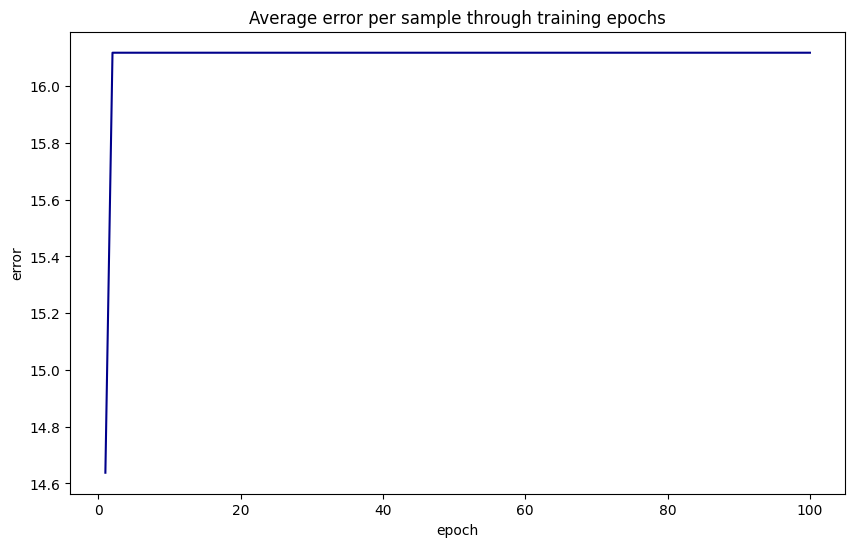

In [183]:
seed = 1234
# network with 3 layers
seed = 1234
# network with 3 layers
net = Network()
net.add(FCLayer(13, 8,seed =  seed))
net.add(FCLayer(8, 8,seed =  seed))    
net.add(FCLayer(8, 2,seed =  seed))  
net.add(ActivationLayer(tanh, tanh_prime))
# train

net.use(binary_cross_entropy, binary_cross_entropy_prime)

err_vect = net.fit_batch(X_train_std, y_train, epochs=100, learning_rate=0.1)
net.plot_error_curve(err_vect)

##################################################
Accuracy on train:  0.7808273145108339
Accuracy on test:  0.7802457466918714
##################################################
Balanced Accuracy on train:  0.7812061099623246
Balanced Accuracy on test:  0.7793051890076439
##################################################
Recall on train:  0.7223382045929019
Recall on test:  0.7319189971070396
##################################################
Precision on train:  0.8206344500444708
Precision on test:  0.8023255813953488
##################################################


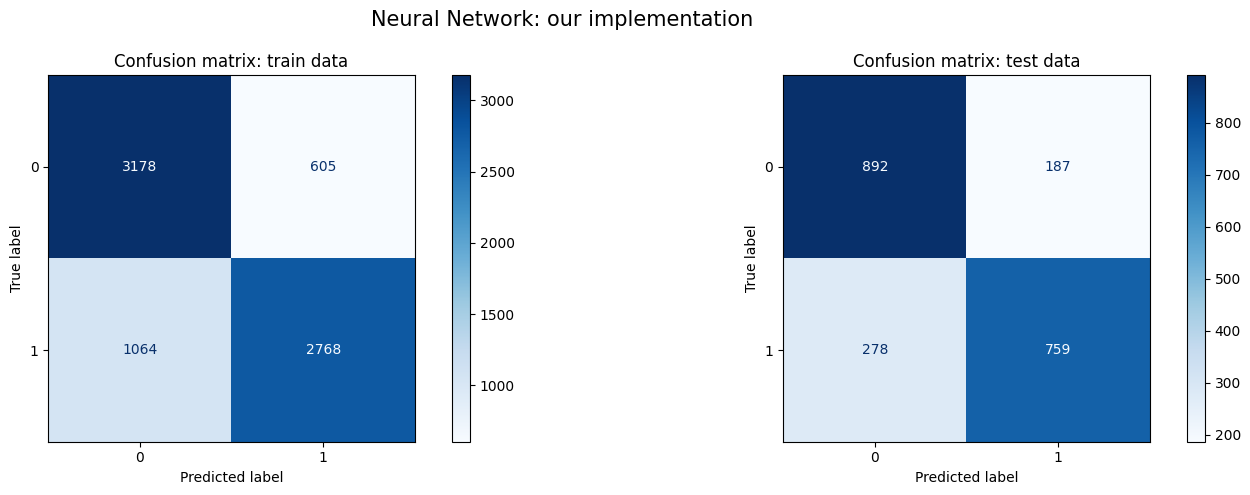

In [187]:
net.nn_evaluate_binary(x_train=X_train_std, y_train=y_train, x_test=X_test_std, y_test=y_test, epochs=100, learning_rate=0.01,mode = 'batch')


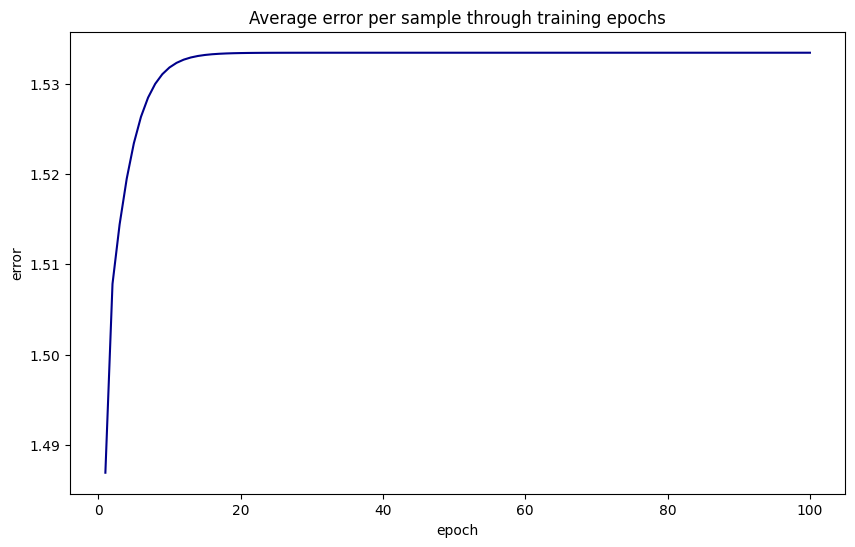

In [188]:
seed = 1234
# network with 3 layers
seed = 1234
# network with 3 layers
net = Network()
net.add(FCLayer(13, 8,seed =  seed))
net.add(FCLayer(8, 8,seed =  seed))    
net.add(FCLayer(8, 2,seed =  seed))  
net.add(ActivationLayer(sigmoid, sigmoid_prime))
# train

net.use(binary_cross_entropy, binary_cross_entropy_prime)

err_vect = net.fit_batch(X_train_std, y_train, epochs=100, learning_rate=0.1)
net.plot_error_curve(err_vect)

##################################################
Accuracy on train:  0.5025607353906762
Accuracy on test:  0.5170132325141777
##################################################
Balanced Accuracy on train:  0.5053118500135482
Balanced Accuracy on test:  0.5086400047188234
##################################################
Recall on train:  0.07776617954070981
Recall on test:  0.08678881388621022
##################################################
Precision on train:  0.5398550724637681
Precision on test:  0.5454545454545454
##################################################


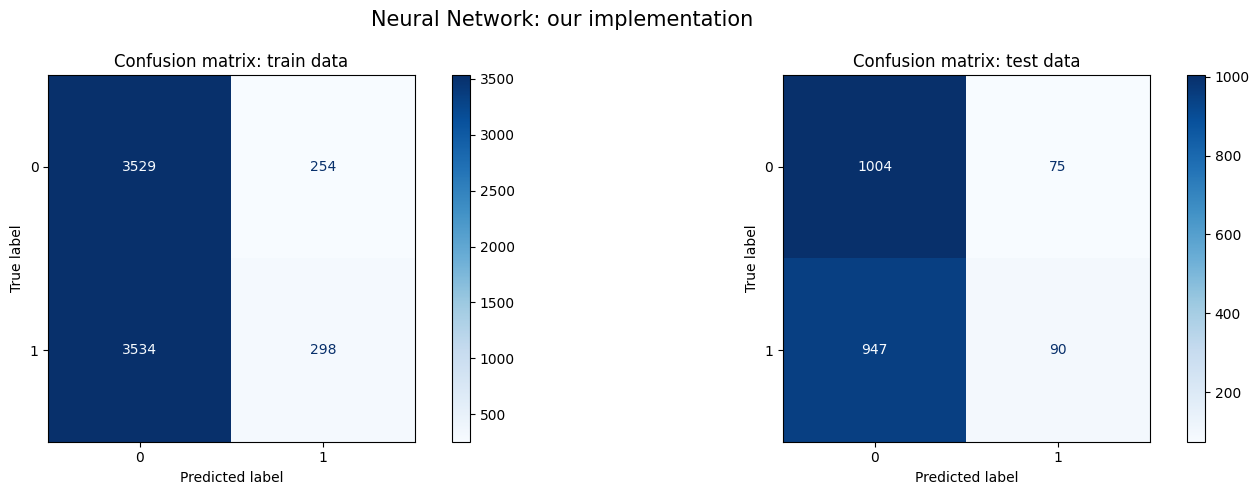

In [189]:
net.nn_evaluate_binary(x_train=X_train_std, y_train=y_train, x_test=X_test_std, y_test=y_test, epochs=100, learning_rate=0.01,mode = 'batch')


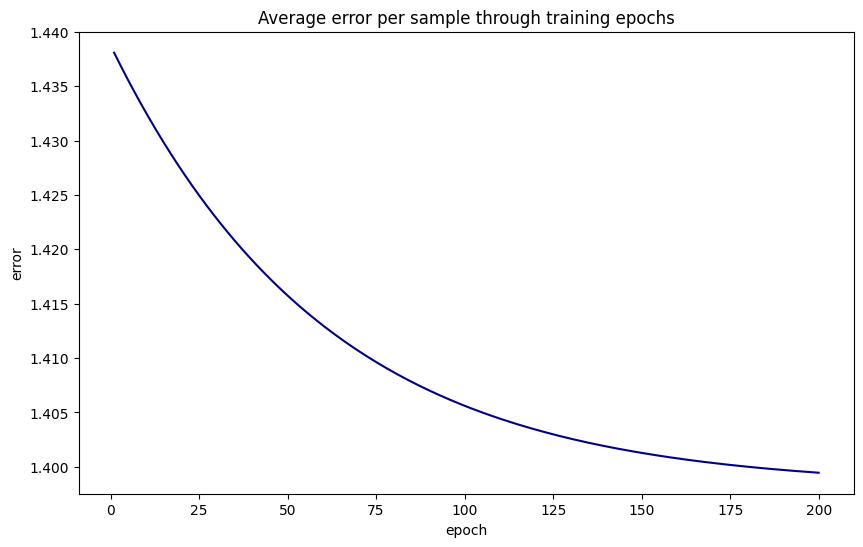

In [190]:
seed = 1234
# network with 3 layers
seed = 1234
# network with 3 layers
net = Network()
net.add(FCLayer(13, 8,seed =  seed))
net.add(ActivationLayer(tanh, tanh_prime))
net.add(FCLayer(8, 8,seed =  seed))    
net.add(ActivationLayer(tanh, tanh_prime))
net.add(FCLayer(8, 2,seed =  seed))  
net.add(ActivationLayer(sigmoid, sigmoid_prime))
# train

net.use(binary_cross_entropy, binary_cross_entropy_prime)

err_vect = net.fit_batch(X_train_std, y_train, epochs=200, learning_rate=0.01)
net.plot_error_curve(err_vect)

##################################################
Accuracy on train:  0.4912672357189757
Accuracy on test:  0.4900756143667297
##################################################
Balanced Accuracy on train:  0.49122758003749334
Balanced Accuracy on test:  0.49010923897354863
##################################################
Recall on train:  0.49739039665970775
Recall on test:  0.4918032786885246
##################################################
Precision on train:  0.4945511157239232
Precision on test:  0.480225988700565
##################################################


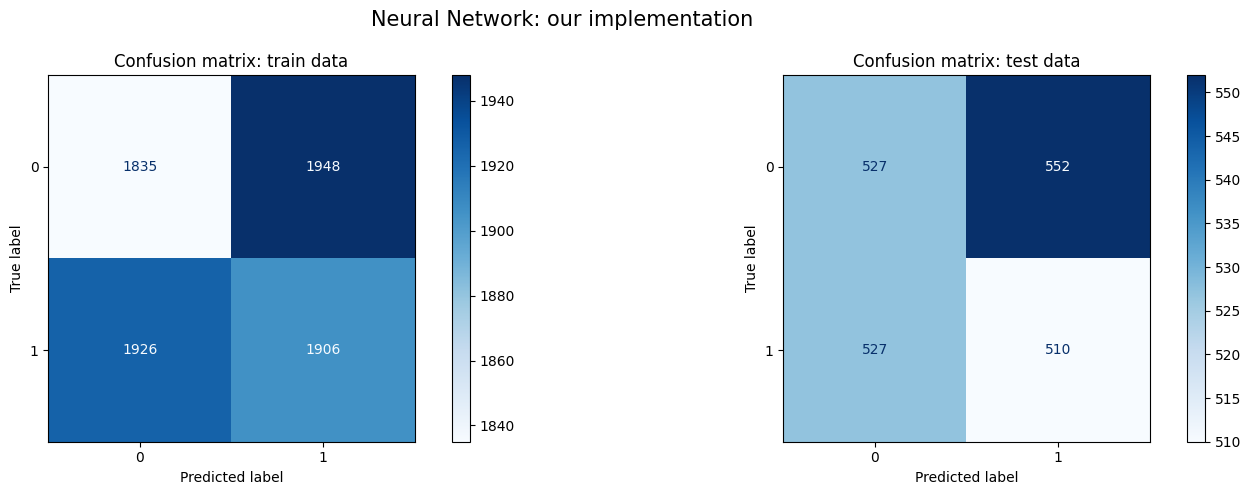

In [191]:
net.nn_evaluate_binary(X_train_std, y_train,X_test_std,y_test, epochs=200, learning_rate=0.01,mode = 'batch')


### Effect of learning rate

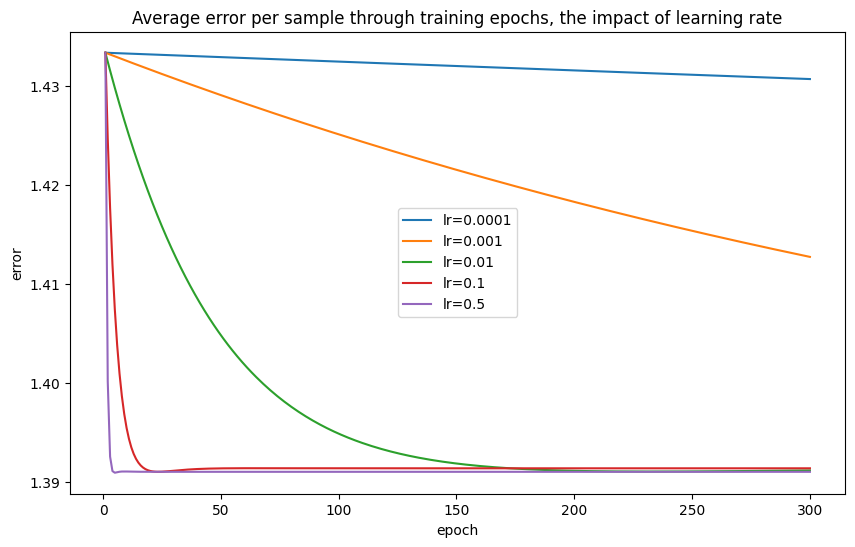

In [18]:
plt.figure(figsize=(10, 6))
plt.xlabel('epoch')
plt.ylabel('error')
plt.title('Average error per sample through training epochs, the impact of learning rate')

lr_vect = np.array([0.0001, 0.001, 0.01, 0.1, 0.5])
k = len(lr_vect)

for i in range(0, k):
    # print(i)
    net = Network()
    net.add(FCLayer(13, 8,seed =  seed))
    net.add(ActivationLayer(tanh, tanh_prime))
    net.add(FCLayer(8, 8,seed =  seed))    
    net.add(ActivationLayer(tanh, tanh_prime))
    net.add(FCLayer(8, 2,seed =  seed))  
    net.add(ActivationLayer(sigmoid, sigmoid_prime))
    # train
    net.use(binary_cross_entropy, binary_cross_entropy_prime)
    lr = lr_vect[i]
    err_vect = net.fit_batch(X_train_std, y_train, epochs=300, learning_rate=lr)

    plt.plot(np.arange(1, len(err_vect)+1, 1), err_vect, '-', label='lr='+str(lr))
    
plt.legend()
plt.show()

The learning rate has a huge effect on how quickly the model converges to an optimal solution. If the learning rate is too high the model may fail to converge (lr = 0.5). On the otherside if it is too low, then the model may require more epochs to reach the optimal solution as in the case of lr = 0.0001.

### Effect of L2 Regularization

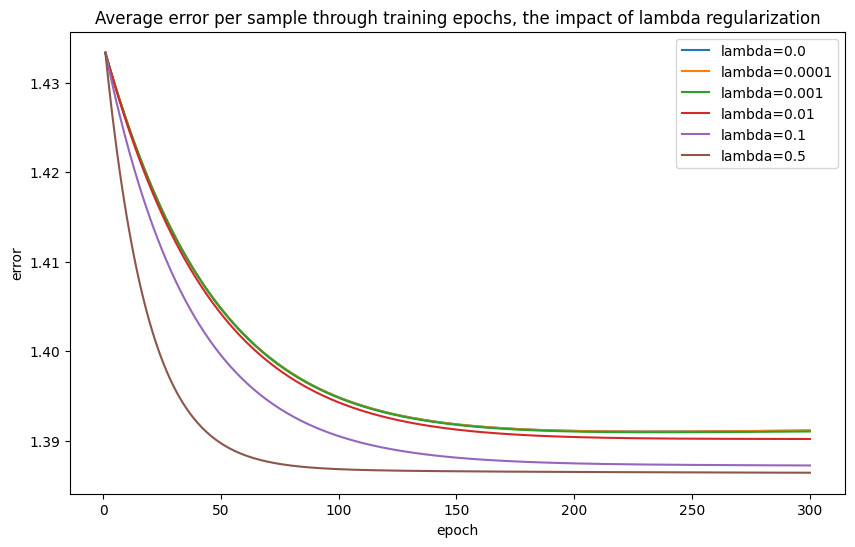

In [19]:
plt.figure(figsize=(10, 6))
plt.xlabel('epoch')
plt.ylabel('error')
plt.title('Average error per sample through training epochs, the impact of lambda regularization')

lambda_vect = np.array([0,0.0001, 0.001, 0.01, 0.1, 0.5])
k = len(lambda_vect)

for i in range(0,k):

    net = Network()
    net.add(FCLayer(13, 8,seed =  seed))
    net.add(ActivationLayer(tanh, tanh_prime))
    net.add(FCLayer(8, 8,seed =  seed))    
    net.add(ActivationLayer(tanh, tanh_prime))
    net.add(FCLayer(8, 2,seed =  seed))  
    net.add(ActivationLayer(sigmoid, sigmoid_prime))
    # train
    net.use(binary_cross_entropy, binary_cross_entropy_prime)
    l = lambda_vect[i]
    err_vect = net.fit_batch(X_train_std, y_train, epochs=300, learning_rate=0.01, reg_lambda = l ,batch_mode = 'ridge')

    plt.plot(np.arange(1, len(err_vect)+1, 1), err_vect, '-', label='lambda='+str(l))
    
plt.legend()
plt.show()


As seen above lambda has quite a huge impact on the training error. Normally, a higher lambda penalizes the weights more and decreases overfitting. Interestingly for this case some higher lambdas led to lower error values, which is quite unusual.

### Randomized Search for best parameter combination

In [25]:
#parameter grid
params = {
    'hidden_layer_size': [2,4,5,6],
    'activation': ['tan+sigmoid','sigmoid'],
    'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.5],
    'reg_lambda' : [0.0001, 0.001,0.01, 0.1, 0.5],
    'epochs': [100,200,300],
    'node_numbers' : [5,8,10,15]
}

input_size = 13
output_size = 2
accuracy_dict = {}
best_accuracy = 0
best_parms = {}
seed = 1234

In [26]:
start = time.time()
random.seed(seed)
#we are going to perform randomized search for 10 randomly chosen parameter combinations
for i in range(10):
    layers = random.sample(params['hidden_layer_size'], 1)[0]
    activation = random.sample(params['activation'], 1)[0]
    learning_rate = random.sample(params['learning_rate'], 1)[0]
    nodes = random.sample(params['node_numbers'], 1)[0]
    epochs = random.sample(params['epochs'], 1)[0]
    reg_lambda =  random.sample(params['reg_lambda'], 1)[0]

    kf = KFold(n_splits=5, shuffle=True,random_state = seed)
    accuracy_scores = []
    for train_index, val_index in kf.split(X_train):
        # Split the data into training and validation sets
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        X_train_fold[:,len(cat_cols)-1:] = scaler.fit_transform(X_train_fold[:,len(cat_cols)-1:])
        X_val_fold[:,len(cat_cols)-1:]  = scaler.transform(X_val_fold[:,len(cat_cols)-1:])

        # Initialize and train your neural network with the current hyperparameters
        net = Network()
        net.add(FCLayer(input_size, nodes,seed = seed))
        if activation == 'sigmoid':
            for _ in range(layers - 1):
                net.add(FCLayer(nodes, nodes,seed = seed))
        else:
            net.add(ActivationLayer(tanh, tanh_prime))
            for _ in range(layers - 1):
                net.add(FCLayer(nodes, nodes,seed = seed))
                net.add(ActivationLayer(tanh, tanh_prime))
        net.add(FCLayer(nodes, output_size,seed = seed))
        net.add(ActivationLayer(sigmoid, sigmoid_prime))
        net.use(binary_cross_entropy, binary_cross_entropy_prime)

        net.fit_batch(X_train_fold, y_train_fold, epochs=epochs, learning_rate=learning_rate,reg_lambda = reg_lambda,batch_mode = 'ridge')
        y_val_pred = net.predict(X_val_fold)
        y_val_pred = np.concatenate(y_val_pred)

        # Convert one-hot encoded predictions back to class labels
        y_val_pred_labels = np.argmax(y_val_pred, axis=1)
        y_val_labels = np.argmax(y_val_fold, axis=1)

        accuracy = accuracy_score(y_val_labels,y_val_pred_labels)
        accuracy_scores.append(accuracy)
    avg_accuracy = np.mean(accuracy_scores)
    if avg_accuracy > best_accuracy:
                    best_accuracy = avg_accuracy
                    best_params = {
                        'hidden_layer_size': layers,
                        'number_of_nodes':nodes,
                        'activation': activation,
                        'learning_rate': learning_rate,
                        'reg_lambda':reg_lambda,
                        'epochs':epochs}
    
    accuracy_dict[(layers,activation,nodes,learning_rate,reg_lambda,epochs)] = accuracy_scores

end = time.time()

/Users/nadia/Desktop/TUSS23/ML/Exercise 2/MachineLearningEx2/neuralnetwork.py:547: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-x))
/Users/nadia/Desktop/TUSS23/ML/Exercise 2/MachineLearningEx2/neuralnetwork.py:547: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-x))
/Users/nadia/Desktop/TUSS23/ML/Exercise 2/MachineLearningEx2/neuralnetwork.py:547: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-x))
/Users/nadia/Desktop/TUSS23/ML/Exercise 2/MachineLearningEx2/neuralnetwork.py:547: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-x))
/Users/nadia/Desktop/TUSS23/ML/Exercise 2/MachineLearningEx2/neuralnetwork.py:547: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-x))


In [27]:
print("Time needed to run cross validation for best parameter combination "+ str((end-start)/60)+ " minutes.")

Time needed to run cross validation for best parameter combination 86.88721633354822 minutes.


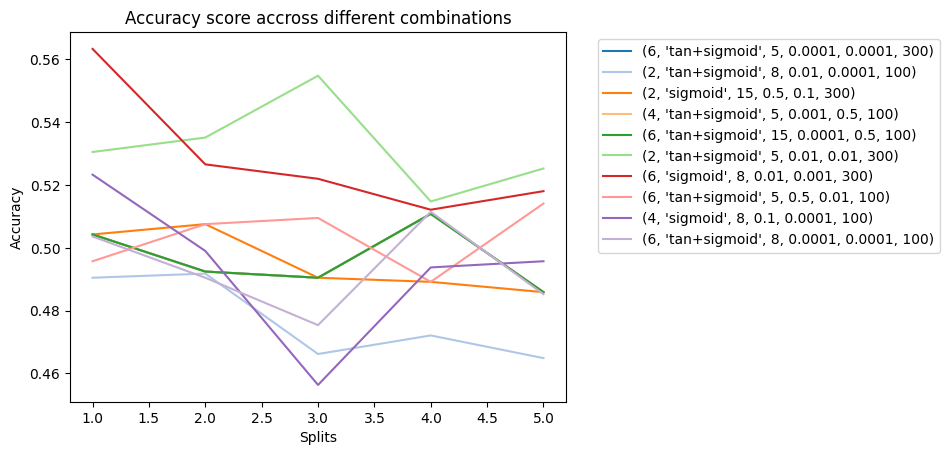

In [28]:
cmap = plt.get_cmap('tab20')
for i,c in enumerate(accuracy_dict):
   color = cmap(i)
   plt.plot(np.arange(1, len(accuracy_dict[c])+1, 1), accuracy_dict[c], '-', label=str(c),color = color)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Accuracy score accross different combinations")
plt.ylabel('Accuracy')
plt.xlabel('Splits')
plt.show()

In [30]:
print(f'The highest accuracy of {best_accuracy} was achieved with the following parameters:\n {best_params}')

The highest accuracy of 0.532107682206172 was achieved with the following parameters:
 {'hidden_layer_size': 2, 'number_of_nodes': 5, 'activation': 'tan+sigmoid', 'learning_rate': 0.01, 'reg_lambda': 0.01, 'epochs': 300}


### Testing the best model on test set

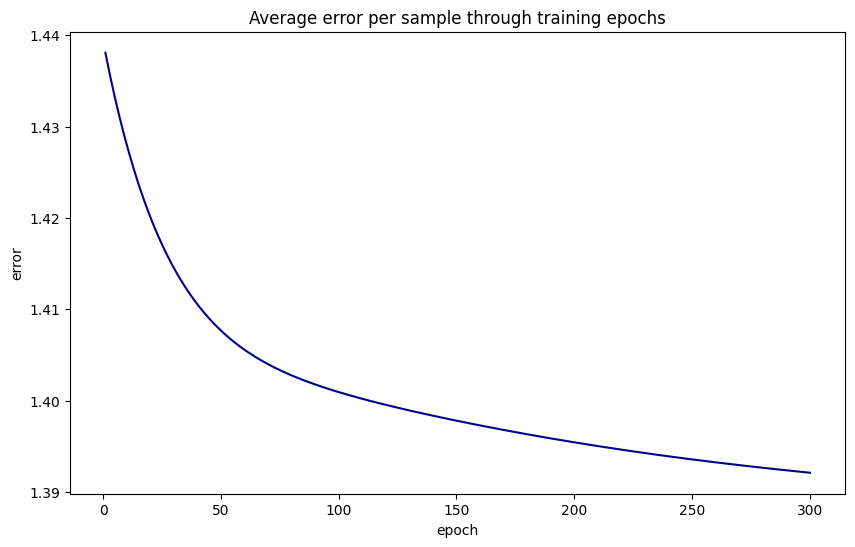

In [31]:
seed = 1234
net = Network()
net.add(FCLayer(13, 5,seed =  seed))
net.add(ActivationLayer(tanh, tanh_prime))
net.add(FCLayer(5, 5,seed =  seed))    
net.add(ActivationLayer(tanh, tanh_prime))
net.add(FCLayer(5, 5,seed =  seed))
net.add(ActivationLayer(tanh, tanh_prime))
net.add(FCLayer(5, 2,seed =  seed)) 
net.add(ActivationLayer(sigmoid, sigmoid_prime))
net.use(binary_cross_entropy, binary_cross_entropy_prime)
net.fit_batch(X_train_std, y_train, epochs=300, learning_rate=0.01,reg_lambda = 0.01, batch_mode = 'ridge')
net.plot_error_curve(err_vect)


##################################################
Accuracy on train:  0.39776756401838476
Accuracy on test:  0.41540642722117205
##################################################
Balanced Accuracy on train:  0.3972119461473894
Balanced Accuracy on test:  0.4173061953324759
##################################################
Recall on train:  0.4835594989561587
Recall on test:  0.5130183220829315
##################################################
Precision on train:  0.4154708520179372
Precision on test:  0.4208860759493671
##################################################


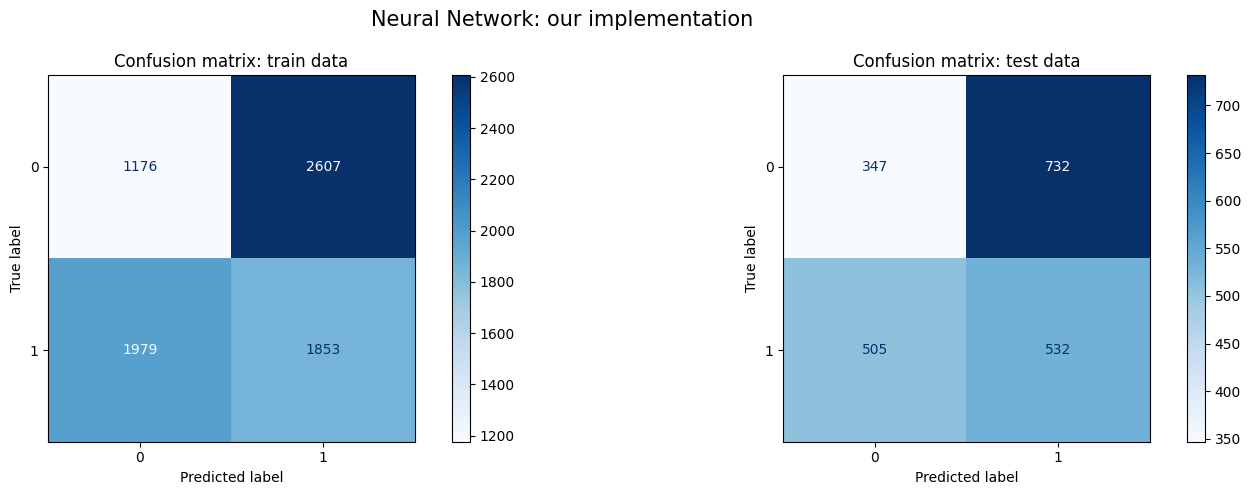

In [32]:
net.nn_evaluate_binary(x_train=X_train_std, y_train=y_train, x_test=X_test_std, y_test=y_test, epochs=300, learning_rate=0.01, mode='batch', reg_lambda=0.01, batch_mode='ridge')


### Comparison: effectiveness & efficiency (for the best model)

In [33]:
seed = 1234
net = Network()
net.add(FCLayer(13, 5,seed =  seed))
net.add(ActivationLayer(tanh, tanh_prime))
net.add(FCLayer(5, 5,seed =  seed))    
net.add(ActivationLayer(tanh, tanh_prime))
net.add(FCLayer(5, 5,seed =  seed))
net.add(ActivationLayer(tanh, tanh_prime))
net.add(FCLayer(5, 2,seed =  seed)) 
net.add(ActivationLayer(sigmoid, sigmoid_prime))
net.use(binary_cross_entropy, binary_cross_entropy_prime)

num_samples = y_train.shape[0]
batch_size_vect = np.array([100]) # training takes too long :(
combinations = len(batch_size_vect) + 2

acc_train = np.zeros(combinations)
acc_test = np.zeros(combinations)
elapsed_time = np.zeros(combinations)


# 0. incremental approach
start = time.time()
acc_train[0], acc_test[0] = net.nn_evaluate_one_hot_without_plotting(x_train=X_train_std, y_train=y_train, x_test=X_test_std, y_test=y_test, epochs=300, learning_rate=0.01, mode='batch', reg_lambda=0.01, batch_mode='ridge')
end = time.time()
elapsed_time[0] = end - start

# mini-batch approach
for i in range(0, len(batch_size_vect)):
    print(i)
    seed = 1234
    net = Network()
    net.add(FCLayer(13, 5,seed =  seed))
    net.add(ActivationLayer(tanh, tanh_prime))
    net.add(FCLayer(5, 5,seed =  seed))    
    net.add(ActivationLayer(tanh, tanh_prime))
    net.add(FCLayer(5, 5,seed =  seed))
    net.add(ActivationLayer(tanh, tanh_prime))
    net.add(FCLayer(5, 2,seed =  seed)) 
    net.add(ActivationLayer(sigmoid, sigmoid_prime))

    net.use(binary_cross_entropy, binary_cross_entropy_prime)

    batch_size = batch_size_vect[i]
    start = time.time()
    acc_train[i+1], acc_test[i+1] = net.nn_evaluate_one_hot_without_plotting(x_train=X_train_std, y_train=y_train, x_test=X_test_std, y_test=y_test, epochs=300, learning_rate=0.01, mode='batch', reg_lambda=0.01, batch_mode='ridge')
    end = time.time()
    elapsed_time[i+1] = end - start
    
    
seed = 1234
net = Network()
net.add(FCLayer(13, 5,seed =  seed))
net.add(ActivationLayer(tanh, tanh_prime))
net.add(FCLayer(5, 5,seed =  seed))    
net.add(ActivationLayer(tanh, tanh_prime))
net.add(FCLayer(5, 5,seed =  seed))
net.add(ActivationLayer(tanh, tanh_prime))
net.add(FCLayer(5, 2,seed =  seed)) 
net.add(ActivationLayer(sigmoid, sigmoid_prime))


net.use(binary_cross_entropy, binary_cross_entropy_prime)

# batch approach
start = time.time()
acc_train[combinations-1], acc_test[combinations-1] = net.nn_evaluate_one_hot_without_plotting(x_train=X_train_std, y_train=y_train, x_test=X_test_std, y_test=y_test, epochs=300, learning_rate=0.01, mode='batch', reg_lambda=0.01, batch_mode='ridge')
end = time.time()
elapsed_time[combinations-1] = end - start

0


In [34]:
acc_train_copy = acc_train
acc_test_copy = acc_test
elapsed_time_copy = elapsed_time


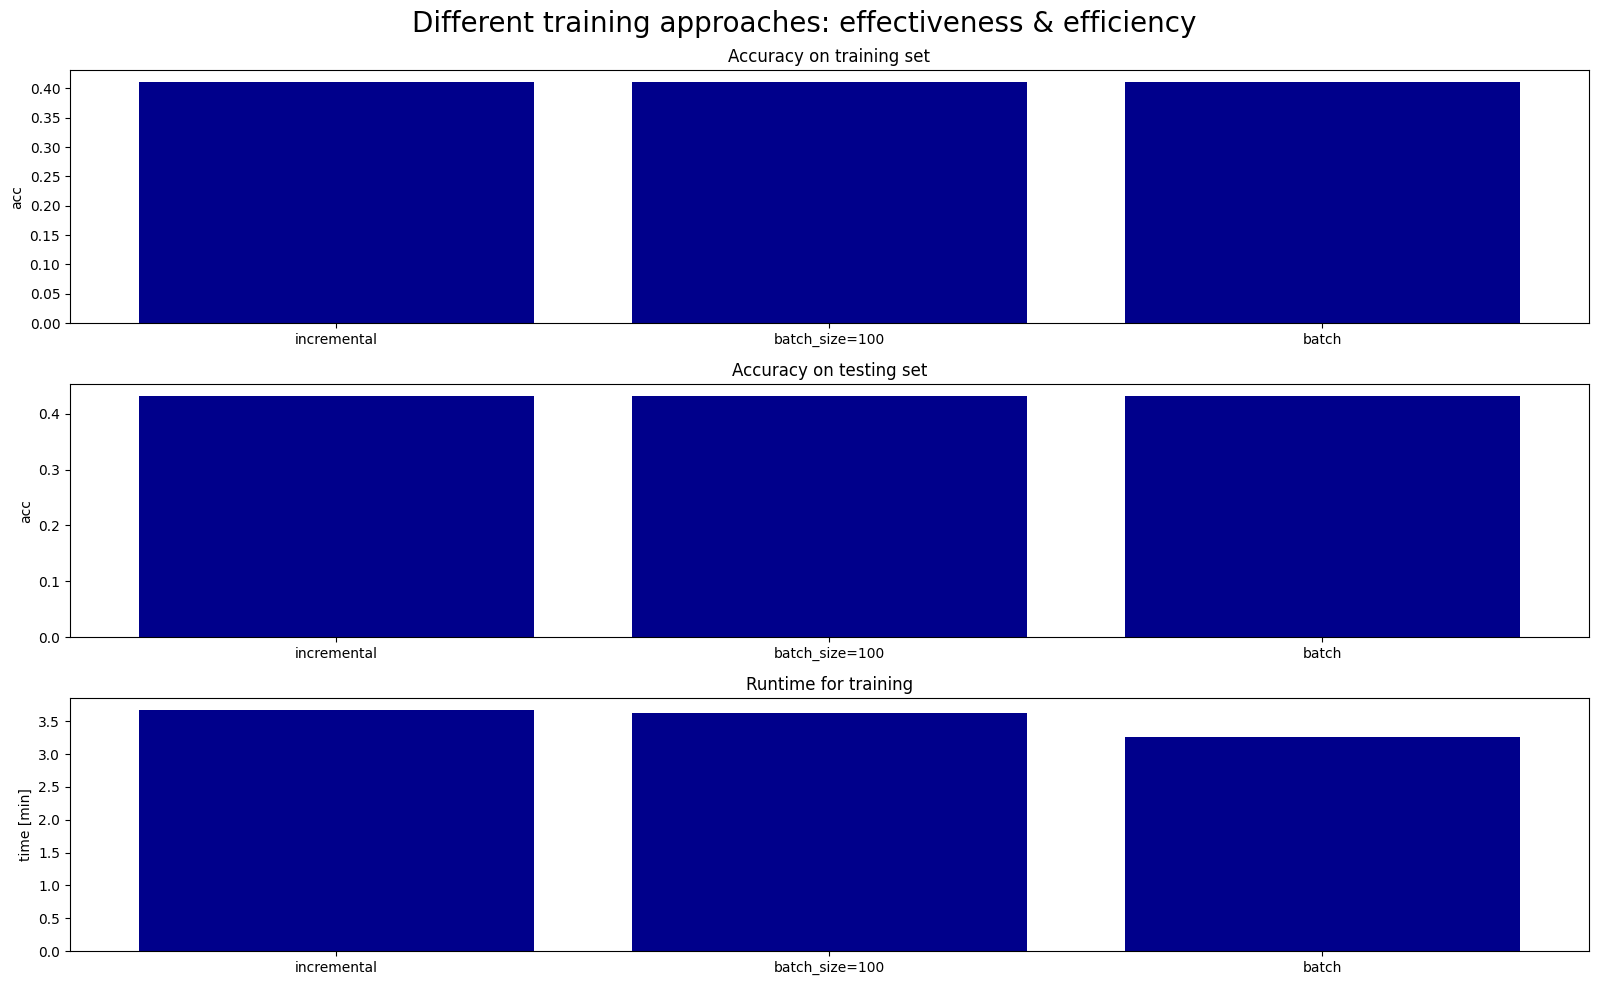

In [35]:
cat = ['incremental', 'batch_size=100', 'batch']
fig, axs = plt.subplots(3, 1, figsize=(16, 10))

axs[0].bar(cat, acc_train, color='darkblue')
axs[0].set_title('Accuracy on training set')
axs[0].set_ylabel('acc')

# Second subplot
axs[1].bar(cat, acc_test, color='darkblue')
axs[1].set_title('Accuracy on testing set')
axs[1].set_ylabel('acc')

# Third subplot
elapsed_time = elapsed_time/60
axs[2].bar(cat, elapsed_time, color='darkblue')
axs[2].set_title('Runtime for training')
axs[2].set_ylabel('time [min]')

plt.suptitle('Different training approaches: effectiveness & efficiency', fontsize=20)
plt.tight_layout()
plt.show()